In [28]:
import requests as r
import getpass, pprint, time, os, cgi, json
import geopandas as gpd
import numpy as np
import shapely
from shapely import Polygon, to_geojson

In [80]:
coords = json.load(open('coords.json'))

target_limit =  "limits_testing_training_chunk" 
xmin, xmax, ymin, ymax = (coords[target_limit]["xmin"]), (coords[target_limit]["xmax"]), (coords[target_limit]["ymin"]), (coords[target_limit]["ymax"])

In [2]:
extract_bnds = np.load("../data-training/Foudre.npy")
extract_dates = np.load("../data-training/Foudre-dates.npy")

In [3]:
api = 'https://appeears.earthdatacloud.nasa.gov/api/'  # Set the AρρEEARS API to a variable

In [4]:
user = getpass.getpass(prompt = 'Enter NASA Earthdata Login Username: ')      # Input NASA Earthdata Login Username
password = getpass.getpass(prompt = 'Enter NASA Earthdata Login Password: ')  # Input NASA Earthdata Login Password

In [5]:
token_response = r.post('{}login'.format(api), auth=(user, password)).json() # Insert API URL, call login service, provide credentials & return json
# del user, password                                                           # Remove user and password information
token_response       

{'token_type': 'Bearer',
 'token': '6lLVkaicIGXZ2n3jYz7Jfyq0-hSZ6i-rPKFVfR1aCIt_av8848WH9PIC72Fka8qNdxPSQpRhLlxA4o3-nhjCEA',
 'expiration': '2023-12-16T16:18:13Z'}

#### Exploring Products

In [6]:
product_response = r.get('{}product'.format(api)).json()                         # request all products in the product service
print('AρρEEARS currently supports {} products.'.format(len(product_response)))

AρρEEARS currently supports 120 products.


In [7]:
products = {p['ProductAndVersion']: p for p in product_response} 

In [8]:
products['DAYMET.004']

{'Product': 'DAYMET',
 'Platform': 'DAYMET',
 'Description': 'Daily Surface Weather Data for North America',
 'RasterType': 'Tile',
 'Resolution': '1000m',
 'TemporalGranularity': 'Daily',
 'Version': '004',
 'Available': True,
 'DocLink': 'https://doi.org/10.3334/ORNLDAAC/2129',
 'Source': 'ORNL',
 'TemporalExtentStart': '1950-01-01',
 'TemporalExtentEnd': '2022-12-31',
 'Deleted': False,
 'DOI': '10.3334/ORNLDAAC/2129',
 'Info': {},
 'ProductAndVersion': 'DAYMET.004'}

#### Choosing the Product

In [9]:
prods = ['MOD13A1.061', 'MOD15A2H.061', 'DAYMET.004']
prods

['MOD13A1.061', 'MOD15A2H.061', 'DAYMET.004']

#### Exploring Layers

In [10]:
mod13a1_response = r.get('{}product/{}'.format(api, prods[0])).json()  # Request layers for the 2nd product (index 1) in the list: MOD11A2.061
list(mod13a1_response.keys())

['_500m_16_days_EVI',
 '_500m_16_days_MIR_reflectance',
 '_500m_16_days_NDVI',
 '_500m_16_days_NIR_reflectance',
 '_500m_16_days_VI_Quality',
 '_500m_16_days_blue_reflectance',
 '_500m_16_days_composite_day_of_the_year',
 '_500m_16_days_pixel_reliability',
 '_500m_16_days_red_reflectance',
 '_500m_16_days_relative_azimuth_angle',
 '_500m_16_days_sun_zenith_angle',
 '_500m_16_days_view_zenith_angle']

In [11]:
mod13a1_response['_500m_16_days_EVI'], mod13a1_response['_500m_16_days_NDVI']

({'AddOffset': 0.0,
  'Available': True,
  'DataType': 'float32',
  'Description': '500m 16 days EVI',
  'Dimensions': ['time', 'YDim', 'XDim'],
  'FillValue': -3000,
  'FillValueRaw': '-3000',
  'Group': '',
  'IsQA': False,
  'Layer': '_500m_16_days_EVI',
  'OrigDataType': 'int16',
  'OrigValidMax': 10000,
  'OrigValidMin': -2000,
  'QualityLayers': "['_500m_16_days_VI_Quality']",
  'QualityProductAndVersion': 'MOD13A1.061',
  'ScaleFactor': 0.0001,
  'Units': '',
  'ValidMax': 1.0,
  'ValidMin': -0.200000003,
  'XSize': 2400,
  'YSize': 2400},
 {'AddOffset': 0.0,
  'Available': True,
  'DataType': 'float32',
  'Description': '500m 16 days NDVI',
  'Dimensions': ['time', 'YDim', 'XDim'],
  'FillValue': -3000,
  'FillValueRaw': '-3000',
  'Group': '',
  'IsQA': False,
  'Layer': '_500m_16_days_NDVI',
  'OrigDataType': 'int16',
  'OrigValidMax': 10000,
  'OrigValidMin': -2000,
  'QualityLayers': "['_500m_16_days_VI_Quality']",
  'QualityProductAndVersion': 'MOD13A1.061',
  'ScaleFactor

#### Choosing the Layers

In [12]:
layers = [(prods[0], '_500m_16_days_EVI'), (prods[0], '_500m_16_days_NDVI'), (prods[1], "Lai_500m"), (prods[2], 'prcp'), (prods[2], 'tmax'), (prods[2], 'tmin')]

In [13]:
prodLayer = []
for l in layers:
    prodLayer.append({
            "layer": l[1],
            "product": l[0]
          })
prodLayer

[{'layer': '_500m_16_days_EVI', 'product': 'MOD13A1.061'},
 {'layer': '_500m_16_days_NDVI', 'product': 'MOD13A1.061'},
 {'layer': 'Lai_500m', 'product': 'MOD15A2H.061'},
 {'layer': 'prcp', 'product': 'DAYMET.004'},
 {'layer': 'tmax', 'product': 'DAYMET.004'},
 {'layer': 'tmin', 'product': 'DAYMET.004'}]

#### Setting the Polygon

In [81]:
poly = Polygon([[xmin, ymin], [xmin, ymax], [xmax, ymax], [xmax, ymin]])
features = [{'type': 'Feature', 'properties': {}, 'geometry': shapely.geometry.mapping(poly)}]

nps_gc = {"type":"FeatureCollection", "features":features}

### The Request

In [14]:
token = token_response['token']                      # Save login token to a variable
head = {'Authorization': 'Bearer {}'.format(token)}  # Create a header to store token information, needed to submit a request

In [82]:

task_type = ['point','area']        # Type of task, area or point
proj = 'geographic'  # Set output projection 
outFormat = ['geotiff', 'netcdf4']  # Set output file format type
startDate = '07-01-2017'            # Start of the date range for which to extract data: MM-DD-YYYY
endDate = '07-01-2017'              # End of the date range for which to extract data: MM-DD-YYYY
recurring = False                   # Specify True for a recurring date range
#yearRange = [2000,2016]            # if recurring = True, set yearRange, change start/end date to MM-DD

In [84]:
task = {
    'task_type': task_type[1],
    'task_name': "Test",
    'params': {
         'dates': [
         {
             'startDate': startDate,
             'endDate': endDate
         }],
         'layers': prodLayer,
         'output': {
                 'format': {
                         'type': outFormat[0]}, 
                         'projection': proj},
         'geo': nps_gc,
    }
}

In [85]:
task_response = r.post('{}task'.format(api), json=task, headers=head).json()  # Post json to the API task service, return response as json
task_response      

{'task_id': '3c0ea761-d1cc-4113-a92a-089ecf58abbd', 'status': 'pending'}

In [86]:
params = {'limit': 2, 'pretty': True} # Limit API response to 2 most recent entries, return as pretty json

In [87]:
tasks_response = r.get('{}task'.format(api), params=params, headers=head).json() # Query task service, setting params and header 
tasks_response      

[{'tier': 2,
  'error': None,
  'params': {'dates': [{'endDate': '07-01-2017', 'startDate': '07-01-2017'}],
   'layers': [{'layer': '_500m_16_days_EVI', 'product': 'MOD13A1.061'},
    {'layer': '_500m_16_days_NDVI', 'product': 'MOD13A1.061'},
    {'layer': 'Lai_500m', 'product': 'MOD15A2H.061'},
    {'layer': 'prcp', 'product': 'DAYMET.004'},
    {'layer': 'tmax', 'product': 'DAYMET.004'},
    {'layer': 'tmin', 'product': 'DAYMET.004'}],
   'output': {'format': {'type': 'geotiff'}, 'projection': 'geographic'}},
  'status': 'processing',
  'created': '2023-12-14T21:17:42.363776',
  'task_id': '3c0ea761-d1cc-4113-a92a-089ecf58abbd',
  'updated': '2023-12-14T21:17:51.275752',
  'user_id': 'xubill0707@gmail.com',
  'estimate': {'request_size': 5566.278091108419, 'request_memory': 1},
  'retry_at': None,
  'has_swath': False,
  'task_name': 'Test',
  'task_type': 'area',
  'api_version': 'v1',
  'svc_version': '3.40.2',
  'web_version': None,
  'has_nsidc_daac': False,
  'expires_on': '2024

In [88]:
task_id = task_response['task_id']                                               # Set task id from request submission
status_response = r.get('{}status/{}'.format(api, task_id), headers=head).json() # Call status service with specific task ID & user credentials
status_response      

{'task_id': '3c0ea761-d1cc-4113-a92a-089ecf58abbd',
 'updated': '2023-12-14T21:17:52.113308',
 'user_id': 'xubill0707@gmail.com',
 'progress': {'details': [{'desc': 'Initializing',
    'step': 1,
    'pct_complete': 0},
   {'desc': 'Downloading', 'step': 2, 'pct_complete': 0},
   {'desc': 'Subsetting', 'step': 3, 'pct_complete': 0},
   {'desc': 'Generating Files', 'step': 4, 'pct_complete': 0},
   {'desc': 'Extracting Stats', 'step': 5, 'pct_complete': 0},
   {'desc': 'Finalizing', 'step': 6, 'pct_complete': 0}],
  'summary': 0,
  'user_consider_limit': True},
 'has_swath': False,
 'status_id': '9c6a51f6-d494-4b25-ab50-43e32cd2bd8e',
 'status_type': 'task'}

In [89]:
# Ping API until request is complete, then continue to Section 4
starttime = time.time()
while r.get('{}task/{}'.format(api, task_id), headers=head).json()['status'] != 'done':
    print(r.get('{}task/{}'.format(api, task_id), headers=head).json()['status'])
    time.sleep(20.0 - ((time.time() - starttime) % 20.0))
print(r.get('{}task/{}'.format(api, task_id), headers=head).json()['status']) 

processing
processing
processing
done


In [90]:
bundle = r.get('{}bundle/{}'.format(api,task_id), headers=head).json()  # Call API and return bundle contents for the task_id as json
bundle

{'files': [{'sha256': 'f652e5dde34091f1c6893e19ee88b20617432ee629ff91bab337f725f69fe7a7',
   'file_id': '1de45272-94db-4568-b8b6-4f8c43da5066',
   'file_name': 'DAYMET.004_2017182_to_2017182/DAYMET.004_prcp_doy2017182_aid0001.tif',
   'file_size': 2730,
   'file_type': 'tif',
   's3_url': 's3://appeears-output/3c0ea761-d1cc-4113-a92a-089ecf58abbd/DAYMET.004_2017182_to_2017182/DAYMET.004_prcp_doy2017182_aid0001.tif'},
  {'sha256': 'c163601a44cc61cf68e95db97c65feb74fd2450331e0b92c56d8db146181434f',
   'file_id': '4a883c62-9173-49ab-b654-ce4d08949279',
   'file_name': 'DAYMET.004_2017182_to_2017182/DAYMET.004_tmax_doy2017182_aid0001.tif',
   'file_size': 2741,
   'file_type': 'tif',
   's3_url': 's3://appeears-output/3c0ea761-d1cc-4113-a92a-089ecf58abbd/DAYMET.004_2017182_to_2017182/DAYMET.004_tmax_doy2017182_aid0001.tif'},
  {'sha256': 'afc547983de94d53a8b0991a58343cee5f1ee464899c50571b6421dfb868ca88',
   'file_id': 'c3e9fa0d-d0ea-4f8e-869c-489b0ee2d52c',
   'file_name': 'DAYMET.004_2017

In [91]:
files = {}                                                       # Create empty dictionary
for f in bundle['files']: files[f['file_id']] = f['file_name']   # Fill dictionary with file_id as keys and file_name as values
files    

{'1de45272-94db-4568-b8b6-4f8c43da5066': 'DAYMET.004_2017182_to_2017182/DAYMET.004_prcp_doy2017182_aid0001.tif',
 '4a883c62-9173-49ab-b654-ce4d08949279': 'DAYMET.004_2017182_to_2017182/DAYMET.004_tmax_doy2017182_aid0001.tif',
 'c3e9fa0d-d0ea-4f8e-869c-489b0ee2d52c': 'DAYMET.004_2017182_to_2017182/DAYMET.004_tmin_doy2017182_aid0001.tif',
 'f50b8a6c-2883-41e5-894e-365609325d88': 'MOD13A1.061_2017167_to_2017182/MOD13A1.061__500m_16_days_EVI_doy2017177_aid0001.tif',
 '1f5c07aa-f876-4ee7-978b-2e0e928f45f8': 'MOD13A1.061_2017167_to_2017182/MOD13A1.061__500m_16_days_NDVI_doy2017177_aid0001.tif',
 '38cdd7c9-f915-4761-bdae-427f4054db4c': 'MOD13A1.061_2017167_to_2017182/MOD13A1.061__500m_16_days_VI_Quality_doy2017177_aid0001.tif',
 '5ff1ae93-4476-447d-b247-6da776ea7865': 'MOD15A2H.061_2017175_to_2017182/MOD15A2H.061_Lai_500m_doy2017177_aid0001.tif',
 'f76e2935-4681-40be-bcc7-27c4d56dc753': 'MOD15A2H.061_2017175_to_2017182/MOD15A2H.061_FparLai_QC_doy2017177_aid0001.tif',
 '55365098-f505-466a-aabe

In [92]:
destDir = "../data-sample"

In [61]:
os.path.exists("../data/MOD15A2H.061_Lai_500m_doy2017185_aid0001.tif")

True

In [93]:
for f in files:
    dl = r.get('{}bundle/{}/{}'.format(api, task_id, f), headers=head, stream=True, allow_redirects = 'True')                                # Get a stream to the bundle file
    if files[f].endswith('.tif'):
        filename = files[f].split('/')[1]
    else:
        filename = files[f] 
    filepath = os.path.join(destDir, filename)                                                       # Create output file path
    with open(filepath, 'wb') as f:                                                                  # Write file to dest dir
        for data in dl.iter_content(chunk_size=8192): f.write(data) 
print('Downloaded files can be found at: {}'.format(destDir))

Downloaded files can be found at: ../data-sample


In [45]:
import matplotlib.pyplot as plt
import numpy as np
from osgeo import gdal
list(files.values())  # List files downloaded

['DAYMET.004_2017182_to_2017212/DAYMET.004_prcp_doy2017182_aid0001.tif',
 'DAYMET.004_2017182_to_2017212/DAYMET.004_prcp_doy2017183_aid0001.tif',
 'DAYMET.004_2017182_to_2017212/DAYMET.004_prcp_doy2017184_aid0001.tif',
 'DAYMET.004_2017182_to_2017212/DAYMET.004_prcp_doy2017185_aid0001.tif',
 'DAYMET.004_2017182_to_2017212/DAYMET.004_prcp_doy2017186_aid0001.tif',
 'DAYMET.004_2017182_to_2017212/DAYMET.004_prcp_doy2017187_aid0001.tif',
 'DAYMET.004_2017182_to_2017212/DAYMET.004_prcp_doy2017188_aid0001.tif',
 'DAYMET.004_2017182_to_2017212/DAYMET.004_prcp_doy2017189_aid0001.tif',
 'DAYMET.004_2017182_to_2017212/DAYMET.004_prcp_doy2017190_aid0001.tif',
 'DAYMET.004_2017182_to_2017212/DAYMET.004_prcp_doy2017191_aid0001.tif',
 'DAYMET.004_2017182_to_2017212/DAYMET.004_prcp_doy2017192_aid0001.tif',
 'DAYMET.004_2017182_to_2017212/DAYMET.004_prcp_doy2017193_aid0001.tif',
 'DAYMET.004_2017182_to_2017212/DAYMET.004_prcp_doy2017194_aid0001.tif',
 'DAYMET.004_2017182_to_2017212/DAYMET.004_prcp_doy

In [95]:
dem = gdal.Open("../data-sample/MOD13A1.061__500m_16_days_NDVI_doy2017177_aid0001.tif") # Read file in
demBand = dem.GetRasterBand(1)                                          # Read the band (layer)
demData = demBand.ReadAsArray().astype('float')                         # Import band as an array with type float
demFill = demBand.GetNoDataValue()            # Returns fill value
demData[demData == demFill] = np.nan          # Set fill value to nan

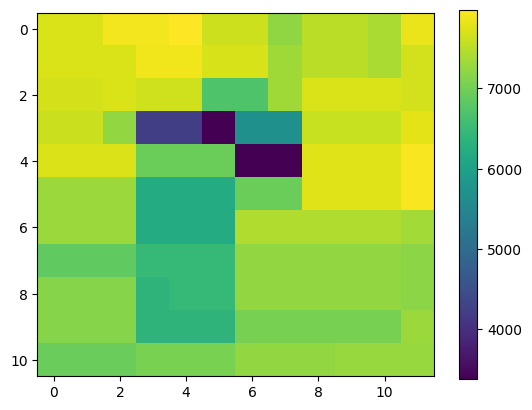

In [96]:
plt.imshow(demData);  # Visualize a basic plot of the DEM data
plt.colorbar()


##### Optional Normalization

In [70]:
from sklearn.preprocessing import normalize

In [78]:
normed_matrix = (demData-np.min(demData))/(np.max(demData)-np.min(demData))